In [ ]:
# Real scalar boson star or oscillaton example
# see further details in https://github.com/GRChombo/engrenage/wiki/Running-the-oscillaton-example

# restart the kernel to clear past work
# (can also do this manually from the Kernel options above)
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [1]:
# load the required python modules
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import time
import random
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# homemade source code from source folder
sys.path.append('../source')

from core.grid import Grid
from core.rhsevolution import *
from core.spacing import *
from core.display import * 
from core.statevector import *
from matter.scalarmatter import *
from initialdata.oscillatoninitialconditions import *
from backgrounds.sphericalbackground import *
from bssn.constraintsdiagnostic import *

In [2]:
# Set up the chosen matter class
scalar_mu = 1.0
my_matter = ScalarMatter(scalar_mu)
my_state_vector = StateVector(my_matter)

# Input parameters for grid and evolution here
r_max = 64 # outer edge of the grid (including ghosts)
min_dr = 1 / 4
max_dr = 2

# SinhSpacing
# params = SinhSpacing.get_parameters(r_max, min_dr, max_dr)
# spacing = SinhSpacing(**params)

# CubicSpacing
params = CubicSpacing.get_parameters(r_max, min_dr, max_dr)
spacing = CubicSpacing(**params)

grid = Grid(spacing, my_state_vector)
r = grid.r
num_points = r.size
background = FlatSphericalBackground(r)

# Check grid params
print(params)

{'r_max': 64, 'extent': <SpacingExtent.HALF: 0>, 'a': 7.256917881777163, 'num_points': 81}


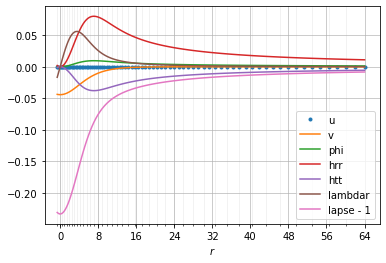

In [3]:
initial_state = get_initial_state(grid, background)

#unpackage the vector for readability
(initial_phi, initial_hrr, initial_htt, initial_hpp, 
 initial_K, initial_arr, initial_att, initial_app, 
 initial_lambdar, initial_shiftr, initial_br, initial_lapse,
 initial_u, initial_v) = np.array_split(initial_state, grid.NUM_VARS)

#plot initial conditions
plt.xlabel('r')
plt.plot(r, initial_u, '.', label='u') # zero, but plot as dots to see the grid
plt.plot(r, initial_v, label='v')
plt.plot(r, initial_phi, label='phi')
plt.plot(r, initial_hrr, label='hrr')
plt.plot(r, initial_htt, label='htt')
plt.plot(r, initial_lambdar, label='lambdar')
#plt.plot(r, initial_shiftr, label='shiftr')
plt.plot(r, initial_lapse-1, label='lapse - 1')
plt.legend(loc='best')
ax = plt.gcf().gca()
set_grid_on_ax(ax, r)
#plt.xlim(-0.25,5.0)
#plt.ylim(-0.0005,0.0005)

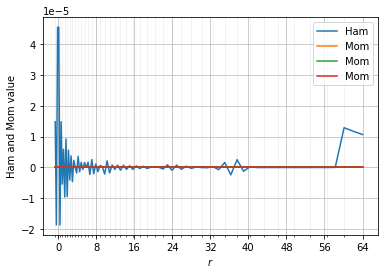

In [4]:
# check the Hamiltonian constraint initially satisfied
# apart from numerical errors
Ham, Mom = get_constraints_diagnostic(initial_state, np.array([0]), grid, background, my_matter)

# plot the profile for Ham
plt.plot(r, Ham[0], label="Ham")
plt.plot(r, Mom[0], label="Mom")

plt.xlabel('r')
plt.legend(loc="best")
#plt.xlim(-4.0,max_r)
#plt.ylim(-0.01,0.01)
plt.ylabel('Ham and Mom value')
ax = plt.gcf().gca()
set_grid_on_ax(ax, r)

In [5]:
# for control of time integrator and spatial grid
T = 10.0 # Maximum evolution time
num_points_t = 101 # time resolution (only for outputs, not for integration)

# Work out dt and time spacing of outputs
dt = T/num_points_t
t = np.linspace(0, T-dt, num_points_t)

# Solve for the solution using RK45 integration of the ODE
# to make like (older) python odeint method use method='LSODA' instead
# use tqdm package to track progress
with tqdm(total=1000, unit="‰") as progress_bar:
    dense_solution = solve_ivp(get_rhs, [0,T], initial_state, 
                               args=(grid, background, my_matter, progress_bar, [0, T/1000]),
                        #atol=1e-5, rtol=1e-5,
                        max_step = 0.4 * min_dr, #for stability and for KO coeff of 1
                        method='RK45', dense_output=True)

# Interpolate the solution at the time points defined in myparams.py
solution = dense_solution.sol(t).T

  0%|          | 0/1000 [00:00<?, ?‰/s]

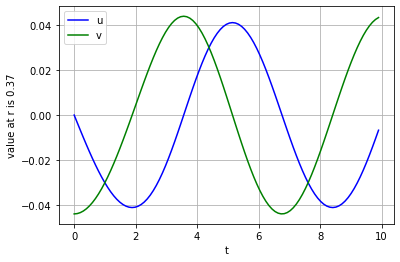

In [6]:
# Plot a single point versus time
var1 = my_matter.idx_u
var2 = my_matter.idx_v

idx = NUM_GHOSTS+1
r_i = np.round(r[idx],2)
var1_of_t = solution[:, var1 * num_points + idx]
plt.plot(t, var1_of_t, 'b-', label=my_state_vector.VARIABLE_NAMES[var1])
var2_of_t = solution[:, var2 * num_points + idx]
plt.plot(t, var2_of_t, 'g-', label=my_state_vector.VARIABLE_NAMES[var2])
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('value at r is '+str(r_i))
plt.legend(loc='best')
plt.grid()

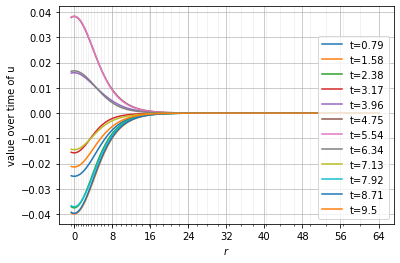

In [7]:
# plot the profile for some variable at a selection of times
var = my_matter.idx_u # I suggest looking at the field u, or the lapse to see the gauge evolution

for i, t_i in enumerate(t) :
    if (i < num_points_t) and (i % 8 == 0) and (t_i > 0.0):
        labelt = "t="+str(round(t_i,2))
        f_t = solution[i, var * num_points: (var + 1) * num_points]
        plt.plot(r, f_t, label=labelt)

plt.legend(loc=4)
plt.xlabel('r')
plt.ylabel('value over time of ' + my_state_vector.VARIABLE_NAMES[var])
ax = plt.gcf().gca()
set_grid_on_ax(ax, r)
#plt.xlim(-0.2,40.0)
#plt.ylim(-0.001,0.001)

In [8]:
# calculate the diagnostics, just the Hamiltonian constraint for now
Ham, Mom = get_constraints_diagnostic(solution, t, grid, background, my_matter)

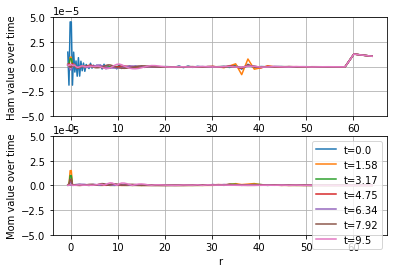

In [9]:
# plot the profile for Ham and Mom at a selection of times

for i, t_i in enumerate(t) :
    if (i < num_points_t) and (i % 16 == 0) :
        labelt = "t="+str(round(t_i,2))
        Ham_t = Ham[i,:]
        ax1 = plt.subplot(211)
        plt.plot(r, Ham_t, label=labelt)
        ax2 = plt.subplot(212)
        Mom_t = np.sqrt(Mom[i,:,i_r]**2 + Mom[i,:,i_t]**2 + Mom[i,:,i_p]**2)
        plt.plot(r, Mom_t, label=labelt)

plt.legend()
ax2.set_xlabel('r')
ax1.set_ylabel('Ham value over time')
# ax1.set_xlim(-1,20.0)
ax1.set_ylim(-5e-5,5e-5)
ax1.grid()
ax2.set_ylabel('Mom value over time')
# ax2.set_xlim(-1,20.0)
ax2.set_ylim(-5e-5,5e-5)
ax2.grid();

In [11]:
# Animation of the fields (u, v) varying in time
from matplotlib import animation
%matplotlib notebook

# Select variable to plot (u or v)
var_to_plot_id, var_label = my_matter.idx_u, r'$u(t,r)$'
#var_to_anim_id, var_label = my_matter.idx_uidx_v, r'$v(t,r)$'

# Pick it out of the solution vector
var_to_anim = solution[:, var_to_plot_id * num_points:var_to_plot_id * num_points + num_points]

# Set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(r[NUM_GHOSTS], r[-NUM_GHOSTS]), ylim=(1.1*np.min(var_to_anim), 1.1*np.max(var_to_anim)))
line, = plt.plot([], [], lw=2)
ax.set_xlabel(r'$r$')
ax.set_ylabel(var_label)

def init():
    line.set_data([], [])
    return line,

# Animation function. This is called sequentially
def animate(i):
    x = r[NUM_GHOSTS:-NUM_GHOSTS]
    y = var_to_anim[i][NUM_GHOSTS:-NUM_GHOSTS]
    line.set_data(x, y)
    return line,

# Call the animator
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=np.arange(0,num_points_t,1), interval=100, blit=True)

# Display the animation interactively.
# from IPython.display import HTML
# HTML(anim.to_jshtml())

# Option to save the animation - requires a codec e.g. FFMPEG
#anim.save('./field_animation.mp4', writer = 'ffmpeg', fps = 20)

<IPython.core.display.Javascript object>